In [1]:
import tensorflow as tf
import pandas as pd
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('df_train_clean.csv')
df.head()

,text,target,text_clean
0,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this hastag earthq...
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,"13,000 people receive #wildfires evacuation or...",1,13000 people receive hastag wildfires evacuati...
4,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby hastag alas...


In [3]:
tokenize = tf.keras.preprocessing.text.Tokenizer()

In [4]:
tokenize.fit_on_texts(df.text_clean)
df['text_tokenize'] = tokenize.texts_to_sequences(df.text_clean)
df.head()

,text,target,text_clean,text_tokenize
0,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this hastag earthq...,"[108, 4472, 21, 2, 864, 6, 19, 1, 239, 125, 15..."
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[177, 42, 216, 674, 6738, 6739, 1343]"
2,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[39, 1692, 1563, 5, 2082, 4, 647, 21, 120, 674..."
3,"13,000 people receive #wildfires evacuation or...",1,13000 people receive hastag wildfires evacuati...,"[2808, 55, 4474, 1, 1447, 245, 1344, 4, 85]"
4,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby hastag alas...,"[28, 89, 1165, 19, 316, 20, 6741, 1, 2083, 26,..."


In [5]:
padded = tf.keras.preprocessing.sequence.pad_sequences(df.text_tokenize, padding="post")

In [6]:
tensor_df = tf.data.Dataset.from_tensor_slices((padded, df.target.values))

In [7]:
TAKE_SIZE = int(0.7*df.shape[0])
BATCH_SIZE = 16

train_data = tensor_df.take(TAKE_SIZE).shuffle(TAKE_SIZE)
train_data = train_data.batch(BATCH_SIZE)

test_data = tensor_df.skip(TAKE_SIZE).shuffle(df.shape[0]-TAKE_SIZE)
test_data = test_data.batch(BATCH_SIZE)

In [8]:
for train, target in train_data.take(1):
    print(train)
    print(target)

tf.Tensor(
[[15081   130   981    25    15   138    22     3   647     4   903   806
     16   211     2   225   303    23     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0]
 [ 1538     2     7  2059  1863   519     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0]
 [   85     1 11971 11972    42     9   648  3804    26  2808    21  1030
      5   302     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0]
 [ 8331   954     2    82   312  1298     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0]
 [ 5914     1 12028  1972   819    26  3808    42  1793 12029  1795     1
   5907     0     0     0     0     0     0     0     0     0     0    

In [9]:
vocab_size=len(tokenize.word_index)
vocab_size

18314

In [10]:
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size+1, 128, input_shape=[train.shape[1]]),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1D(64, 5, activation='relu'),
        tf.keras.layers.Conv1D(32, 3, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(32, return_sequences=False),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(2, activation="softmax")
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 34, 128)           2344320   
_________________________________________________________________
batch_normalization (BatchNo (None, 34, 128)           512       
_________________________________________________________________
conv1d (Conv1D)              (None, 30, 64)            41024     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 28, 32)            6176      
_________________________________________________________________
dropout (Dropout)            (None, 28, 32)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 28, 64)            16640     
_________________________________________________________________
lstm_1 (LSTM)                (None, 28, 64)            3

In [12]:
initial_learning_rate = 0.0001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=250,
    decay_rate=0.96,
    staircase=True)

optimizer= tf.keras.optimizers.Adam(
    learning_rate = lr_schedule
)

In [13]:
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())

In [14]:
history = model.fit(train_data, epochs=40, validation_data=test_data)

Epoch 1/40
334/334 [==============================] - 17s 30ms/step - loss: 0.6825 - sparse_categorical_accuracy: 0.5800 - val_loss: 0.6845 - val_sparse_categorical_accuracy: 0.5582.6835 - sparse_categorical_accura - ETA: 5s - loss: 0.6836 - sparse_categorical_accuracy: 0 - ETA: 5s - loss: 0.6835 - sparse_catego - ETA: 3s - loss: 0.6833 - sparse_categorical_ac - ETA: 3s - loss: 0.6831 - sparse_categorical_accura - ETA: 2s - loss: 0.6831 -
Epoch 2/40
334/334 [==============================] - 8s 25ms/step - loss: 0.6207 - sparse_categorical_accuracy: 0.6511 - val_loss: 0.5371 - val_sparse_categorical_accuracy: 0.7447gorical_accuracy: 0 - ETA: 4s - loss: 0.6487 - sparse_categorical_accuracy: 0.61 - ETA: 4s - loss: 0.6482 - sparse_categor - ETA: 2s - loss: 0.6398 - sparse_categoric - ETA: 1s - loss: 0.6305 - sparse_catego
Epoch 3/40
334/334 [==============================] - 8s 25ms/step - loss: 0.3755 - sparse_categorical_accuracy: 0.8523 - val_loss: 0.5727 - val_sparse_categorical_accur

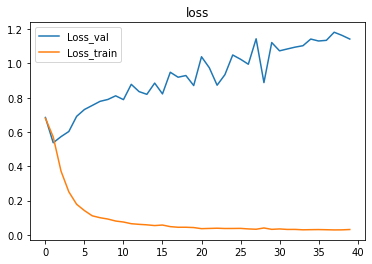

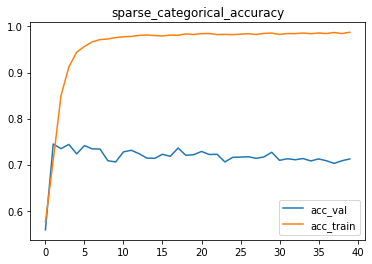

In [15]:
loss_curve = history.history["loss"]
loss_val = history.history["val_loss"]
acc_curve = history.history["sparse_categorical_accuracy"]
acc_val = history.history["val_sparse_categorical_accuracy"]

plt.plot(loss_val,label="Loss_val")
plt.plot(loss_curve,label="Loss_train")
plt.legend()
plt.title("loss")
plt.show()

plt.plot(acc_val, label="acc_val" )
plt.plot(acc_curve, label="acc_train" )
plt.legend()
plt.title("sparse_categorical_accuracy")
plt.show()